## 1. Setup and Imports

In [11]:
# Import libraries
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


## 2. Load All Season Data

In [12]:
# Define data directory
DATA_DIR = 'passing_data/Cavaliers_improve/'  # Update with your data directory
OUTPUT_DIR = 'player_role'

# Create output directory
Path(OUTPUT_DIR).mkdir(exist_ok=True)

In [13]:
# Load all data into a dictionary
season_data = {}
csv_files = sorted(Path(DATA_DIR).glob('*.csv'))

for file_path in csv_files:
    filename = Path(file_path).stem
    season_data[filename] = pd.read_csv(file_path)
    print(f"Loaded {filename}: {len(season_data[filename])} records")

Loaded Cavaliers_passing_data_2020_21: 315 records
Loaded Cavaliers_passing_data_2021_22: 305 records
Loaded Cavaliers_passing_data_2022_23: 232 records
Loaded Cavaliers_passing_data_2023_24: 255 records
Loaded Cavaliers_passing_data_2024_25: 270 records


## 3. Build Graphs for All Seasons

In [14]:
def build_passing_graph(data, weight_column='pass', top_n=12):
    """
    Build a directed weighted graph from passing data.
    Filters to top N players by network strength.
    
    Args:
        data: DataFrame with player_name, pass_to, and weight columns
        weight_column: 'pass' or 'ast'
        top_n: Number of top players to include (default: 12)
    
    Returns:
        NetworkX DiGraph with top N players
    """
    # Build complete graph
    G_full = nx.DiGraph()
    
    for _, row in data.iterrows():
        player = row['player_name']
        pass_to = row['pass_to']
        weight = row[weight_column]
        
        if pd.notna(player) and pd.notna(pass_to) and weight > 0:
            if G_full.has_edge(player, pass_to):
                G_full[player][pass_to]['weight'] += weight
            else:
                G_full.add_edge(player, pass_to, weight=weight)
    
    # Calculate network strength for each player
    players = list(G_full.nodes())
    player_strength = {}
    
    for player in players:
        in_deg = G_full.in_degree(player, weight='weight')
        out_deg = G_full.out_degree(player, weight='weight')
        player_strength[player] = in_deg + out_deg
    
    # Get top N players
    sorted_players = sorted(players, key=lambda p: player_strength[p], reverse=True)
    top_players = sorted_players[:top_n]
    
    # Create subgraph with only top N players
    G_top = G_full.subgraph(top_players).copy()
    
    # Store metadata
    G_top.graph['top_players'] = top_players
    G_top.graph['player_strengths'] = {p: player_strength[p] for p in top_players}
    
    return G_top

In [15]:
# Build pass graphs for all seasons
pass_graphs = {}
TOP_N = 12  # Top 12 players per season

print("\n=== Building Networks (Top 12 Players) ===\n")

for season, data in season_data.items():
    pass_graphs[season] = build_passing_graph(data, 'pass', top_n=TOP_N)
    print(f"{season}:")
    print(f"  Pass: {pass_graphs[season].number_of_edges()} edges")
    print('-'*40)


=== Building Networks (Top 12 Players) ===

Cavaliers_passing_data_2020_21:
  Pass: 128 edges
----------------------------------------
Cavaliers_passing_data_2021_22:
  Pass: 118 edges
----------------------------------------
Cavaliers_passing_data_2022_23:
  Pass: 121 edges
----------------------------------------
Cavaliers_passing_data_2023_24:
  Pass: 130 edges
----------------------------------------
Cavaliers_passing_data_2024_25:
  Pass: 120 edges
----------------------------------------


## 4. Individual Player Centrality Metrics

In [16]:
def calculate_centrality_metrics(G, season, network_type='pass', top_n=12):
    """
    Calculate centrality metrics for top N players by network strength.
    
    Args:
        G: NetworkX DiGraph (complete network)
        season: Season identifier
        network_type: 'pass' or 'assist'
        top_n: Number of top players to analyze (default: 12)
    
    Returns:
        DataFrame with player-level centrality metrics
    """
    
    # Calculate strength (total weighted degree) for all players
    player_strength = {}
    for player in G.nodes():
        in_deg = G.in_degree(player, weight='weight')
        out_deg = G.out_degree(player, weight='weight')
        player_strength[player] = in_deg + out_deg
    
    # Sort by strength (descending) and take top N
    sorted_players = sorted(player_strength.keys(), 
                           key=lambda p: player_strength[p], 
                           reverse=True)
    top_players = sorted_players[:top_n]
    
    # Create subgraph with only top N players
    G_top = G.subgraph(top_players).copy()
    
    # Calculate weighted degrees
    in_degree_weighted = dict(G_top.in_degree(weight='weight'))
    out_degree_weighted = dict(G_top.out_degree(weight='weight'))
    
    # ===== FIX: Use directed centrality measures =====
    # For DIRECTED graphs, calculate in/out centrality separately
    in_degree_centrality = nx.in_degree_centrality(G_top)
    out_degree_centrality = nx.out_degree_centrality(G_top)
    
    # Combined degree centrality (average of in + out, normalized)
    # OR use total_degree_centrality for undirected-style metric
    degree_centrality = {}
    for player in G_top.nodes():
        # Option 1: Average (recommended for interpretation)
        degree_centrality[player] = (in_degree_centrality[player] + 
                                     out_degree_centrality[player]) / 2
        
        # Option 2: Sum (matches your original intent, but can exceed 1.0)
        # degree_centrality[player] = (in_degree_centrality[player] + 
        #                               out_degree_centrality[player])
    
    # Betweenness (directed, uses edge weights as costs - inverse for passing)
    betweenness = nx.betweenness_centrality(G_top, weight=None)  # Unweighted for structure
    
    # Eigenvector (catch convergence issues)
    try:
        eigenvector = nx.eigenvector_centrality(G_top, weight='weight', max_iter=1000)
    except nx.PowerIterationFailedConvergence:
        # Fallback: use undirected version
        G_undirected = G_top.to_undirected()
        eigenvector = nx.eigenvector_centrality(G_undirected, weight='weight', max_iter=1000)
    
    # PageRank (works natively on directed graphs)
    pagerank = nx.pagerank(G_top, weight='weight')
    
    # Closeness (use directed version for pass networks)
    try:
        closeness = nx.closeness_centrality(G_top)  # Directed closeness
    except:
        # Fallback if graph is not strongly connected
        G_undirected = G_top.to_undirected()
        closeness = nx.closeness_centrality(G_undirected)
    
    # ===== NEW: Add pass/receive ratio =====
    pass_receive_ratio = {}
    for player in G_top.nodes():
        if in_degree_weighted[player] > 0:
            pass_receive_ratio[player] = out_degree_weighted[player] / in_degree_weighted[player]
        else:
            pass_receive_ratio[player] = float('inf') if out_degree_weighted[player] > 0 else 0
    
    # Compile results
    results = []
    for player in G_top.nodes():
        results.append({
            'Season': season,
            'Network_Type': network_type,
            'Player': player,
            
            # Raw metrics
            'Passes_Received': in_degree_weighted[player],
            'Passes_Made': out_degree_weighted[player],
            'Total_Passes': in_degree_weighted[player] + out_degree_weighted[player],
            'Pass_Receive_Ratio': pass_receive_ratio[player],
            
            # Rankings
            'Strength_Rank': sorted_players.index(player) + 1,
            
            # Centrality measures (all normalized 0-1)
            'In_Degree_Centrality': in_degree_centrality[player],
            'Out_Degree_Centrality': out_degree_centrality[player],
            'Degree_Centrality': degree_centrality[player],  # Now properly normalized!
            'Betweenness': betweenness[player],
            'Eigenvector': eigenvector[player],
            'PageRank': pagerank[player],
            'Closeness': closeness[player]
        })
    
    return pd.DataFrame(results)

In [17]:
# Calculate centrality metrics for TOP 12 players only
all_centrality_metrics = []

print("Calculating centrality metrics for TOP 12 players (by strength)...\n")
for season in sorted(pass_graphs.keys()):
    # Pass network metrics (top 12)
    pass_metrics = calculate_centrality_metrics(pass_graphs[season], season, 'pass', top_n=12)
    all_centrality_metrics.append(pass_metrics)
    
    print(f"✓ {season}: Top 12 players selected (by passing strength)")

# Combine all metrics
centrality_df = pd.concat(all_centrality_metrics, ignore_index=True)

print(f"\n✓ Total centrality records: {len(centrality_df)}")
print(f"   Expected: {len(pass_graphs)} seasons × 2 networks × 12 players = {len(pass_graphs)*2*12}")

# sort strength rank within each season and network type
centrality_df = centrality_df.sort_values(by=['Season', 'Network_Type', 'Strength_Rank']).reset_index(drop=True)

# rename season to 2020-21, 2021-22, etc.
season_rename_map = {
    'Cavaliers_passing_data_2020_21': '2020-21',
    'Cavaliers_passing_data_2021_22': '2021-22',
    'Cavaliers_passing_data_2022_23': '2022-23',
    'Cavaliers_passing_data_2023_24': '2023-24',
    'Cavaliers_passing_data_2024_25': '2024-25',
}
centrality_df['Season'] = centrality_df['Season'].map(season_rename_map)
centrality_df.head(5)

Calculating centrality metrics for TOP 12 players (by strength)...

✓ Cavaliers_passing_data_2020_21: Top 12 players selected (by passing strength)
✓ Cavaliers_passing_data_2021_22: Top 12 players selected (by passing strength)
✓ Cavaliers_passing_data_2022_23: Top 12 players selected (by passing strength)
✓ Cavaliers_passing_data_2023_24: Top 12 players selected (by passing strength)
✓ Cavaliers_passing_data_2024_25: Top 12 players selected (by passing strength)

✓ Total centrality records: 60
   Expected: 5 seasons × 2 networks × 12 players = 120


,Season,Network_Type,Player,Passes_Received,Passes_Made,Total_Passes,Pass_Receive_Ratio,Strength_Rank,In_Degree_Centrality,Out_Degree_Centrality,Degree_Centrality,Betweenness,Eigenvector,PageRank,Closeness
0,2020-21,pass,Collin Sexton,3304,2449,5753,0.741223,1,1.0,1.0,1.0,0.00404,0.543772,0.186022,1.0
1,2020-21,pass,Darius Garland,3067,2574,5641,0.839257,2,1.0,1.0,1.0,0.00404,0.519736,0.174695,1.0
2,2020-21,pass,Isaac Okoro,1553,1592,3145,1.025113,3,1.0,1.0,1.0,0.00404,0.326511,0.099471,1.0
3,2020-21,pass,Jarrett Allen,1230,1821,3051,1.480488,4,1.0,1.0,1.0,0.00404,0.278687,0.084547,1.0
4,2020-21,pass,Cedi Osman,1553,1426,2979,0.918223,5,1.0,1.0,1.0,0.00404,0.305764,0.098075,1.0


In [18]:
# centrality_df drop other columns, remain Season, Network_Type, Player, Total_Passes, Pass_Receive_Ratio, Eigenvector, PageRank columns
centrality_df = centrality_df[['Season', 'Network_Type', 'Player', 'Total_Passes', 'Pass_Receive_Ratio', 'Eigenvector', 'PageRank']]
centrality_df.head(5)

,Season,Network_Type,Player,Total_Passes,Pass_Receive_Ratio,Eigenvector,PageRank
0,2020-21,pass,Collin Sexton,5753,0.741223,0.543772,0.186022
1,2020-21,pass,Darius Garland,5641,0.839257,0.519736,0.174695
2,2020-21,pass,Isaac Okoro,3145,1.025113,0.326511,0.099471
3,2020-21,pass,Jarrett Allen,3051,1.480488,0.278687,0.084547
4,2020-21,pass,Cedi Osman,2979,0.918223,0.305764,0.098075


## 8. Player Role Classification

Classify players into roles based on their core metrics:


In [21]:
def add_percentile_ranks(df):

    for (season, net_type), group in df.groupby(['Season', 'Network_Type']):
        # Influence metrics (PageRank + Eigenvector)
        df.loc[group.index, 'PageRank_Pct'] = group['PageRank'].rank(pct=True)
        df.loc[group.index, 'Eigenvector_Pct'] = group['Eigenvector'].rank(pct=True)
        
        # Combined influence score
        df.loc[group.index, 'Influence_Pct'] = (
            group['PageRank'].rank(pct=True) + group['Eigenvector'].rank(pct=True)
        ) / 2
        
        # Volume metric
        df.loc[group.index, 'Volume_Pct'] = group['Total_Passes'].rank(pct=True)
        
        # Pass/Receive ratio percentile
        df.loc[group.index, 'PassRatio_Pct'] = group['Pass_Receive_Ratio'].rank(pct=True)
    
    return df


def classify_player_role(row):
    """
    Classify players into 4 roles using influence, volume, and pass ratio.
    
    Roles:
    - Hub-Bridge: Elite influence + Elite volume + Balanced ratio
    - Hub: High influence/volume, but imbalanced (scoring focus)
    - Bridge: Moderate influence, balanced distribution (connector role)
    - Role Player: Lower involvement
    
    Args:
        row: DataFrame row with percentile metrics and pass ratio
    """
    
    influence_pct = row['Influence_Pct']      # PageRank + Eigenvector (0-1)
    volume_pct = row['Volume_Pct']            # Total passes (0-1)
    pass_ratio = row['Pass_Receive_Ratio']    # Passes made / received
    total_passes = row['Total_Passes']        # Absolute volume
    
    # Thresholds
    ELITE_INFLUENCE = 0.90   # Top 25% (3 players per season)
    MOD_INFLUENCE = 0.60    # Top 50% (6 players per season)
    HIGH_VOLUME = 0.70      # Top 33% (4 players per season)
    
    # Balanced ratio range (neither extreme scorer nor extreme distributor)
    BALANCED_MIN = 0.9
    BALANCED_MAX = 1.1
    
    # Minimum involvement threshold (absolute)
    MIN_PASSES = 3500
    IS_BALANCED = BALANCED_MIN <= pass_ratio <= BALANCED_MAX
    
    # --- Classification Logic ---
    
    # Role Player: Low involvement (regardless of other metrics)
    if total_passes < MIN_PASSES:
        return 'Role Player'
    
    # Hub-Bridge: Elite influence + High volume + Balanced distribution
    # (The true orchestrators - high touches, connects everyone, distributes well)
    if influence_pct >= ELITE_INFLUENCE and volume_pct >= HIGH_VOLUME:
        if IS_BALANCED:
            return 'Hub-Bridge'
        else:
            # Elite but imbalanced = still Hub (scoring-focused star)
            return 'Hub'
    
    # Hub: High influence OR high volume, but not balanced distribution
    # (Stars who dominate touches but either score a lot or distribute heavily)
    elif influence_pct >= ELITE_INFLUENCE or volume_pct >= HIGH_VOLUME:
        return 'Hub'
    
    # Bridge: Moderate influence + Balanced distribution
    # (Connectors who facilitate without dominating - glue guys)
    elif influence_pct >= MOD_INFLUENCE and IS_BALANCED:
        return 'Bridge'
    
    # Role Player: Everyone else
    else:
        return 'Role Player'


# Execute classification
centrality_df = add_percentile_ranks(centrality_df)
centrality_df['Role'] = centrality_df.apply(classify_player_role, axis=1)

# Verify distribution
print("\n=== Role Distribution by Season ===")
role_dist = centrality_df[centrality_df['Network_Type'] == 'pass'].groupby(
    ['Season', 'Role']
).size().unstack(fill_value=0)
print(role_dist)
centrality_df


=== Role Distribution by Season ===
Role     Hub  Role Player
Season                   
2020-21    2           10
2021-22    3            9
2022-23    4            8
2023-24    4            8
2024-25    4            8


,Season,Network_Type,Player,Total_Passes,Pass_Receive_Ratio,Eigenvector,PageRank,PageRank_Pct,Eigenvector_Pct,Influence_Pct,Volume_Pct,PassRatio_Pct,Role
0,2020-21,pass,Collin Sexton,5753,0.741223,0.543772,0.186022,1.000000,1.000000,1.000000,1.000000,0.083333,Hub
1,2020-21,pass,Darius Garland,5641,0.839257,0.519736,0.174695,0.916667,0.916667,0.916667,0.916667,0.166667,Hub
2,2020-21,pass,Isaac Okoro,3145,1.025113,0.326511,0.099471,0.833333,0.833333,0.833333,0.833333,0.500000,Role Player
3,2020-21,pass,Jarrett Allen,3051,1.480488,0.278687,0.084547,0.666667,0.666667,0.666667,0.750000,1.000000,Role Player
4,2020-21,pass,Cedi Osman,2979,0.918223,0.305764,0.098075,0.750000,0.750000,0.750000,0.666667,0.250000,Role Player
5,2020-21,pass,Dean Wade,2134,1.447248,0.191477,0.063892,0.583333,0.500000,0.541667,0.583333,0.916667,Role Player
6,2020-21,pass,Larry Nance Jr.,2035,1.355324,0.195497,0.063443,0.500000,0.583333,0.541667,0.500000,0.833333,Role Player
7,2020-21,pass,Damyean Dotson,1693,0.943743,0.158515,0.059438,0.333333,0.333333,0.333333,0.416667,0.333333,Role Player
8,2020-21,pass,Kevin Love,1689,1.116541,0.182467,0.059679,0.416667,0.416667,0.416667,0.333333,0.666667,Role Player
9,2020-21,pass,Taurean Prince,1159,0.964407,0.117593,0.046433,0.250000,0.250000,0.250000,0.250000,0.416667,Role Player


# 10. Roles Distribution Analysis

- High influence indicates a hub because it means: "I’m not just connected — I’m connected to the right people."
- In basketball: The player who gets the ball from stars and gives it to scorers is the hub.
Eigenvector/PageRank find exactly that player.

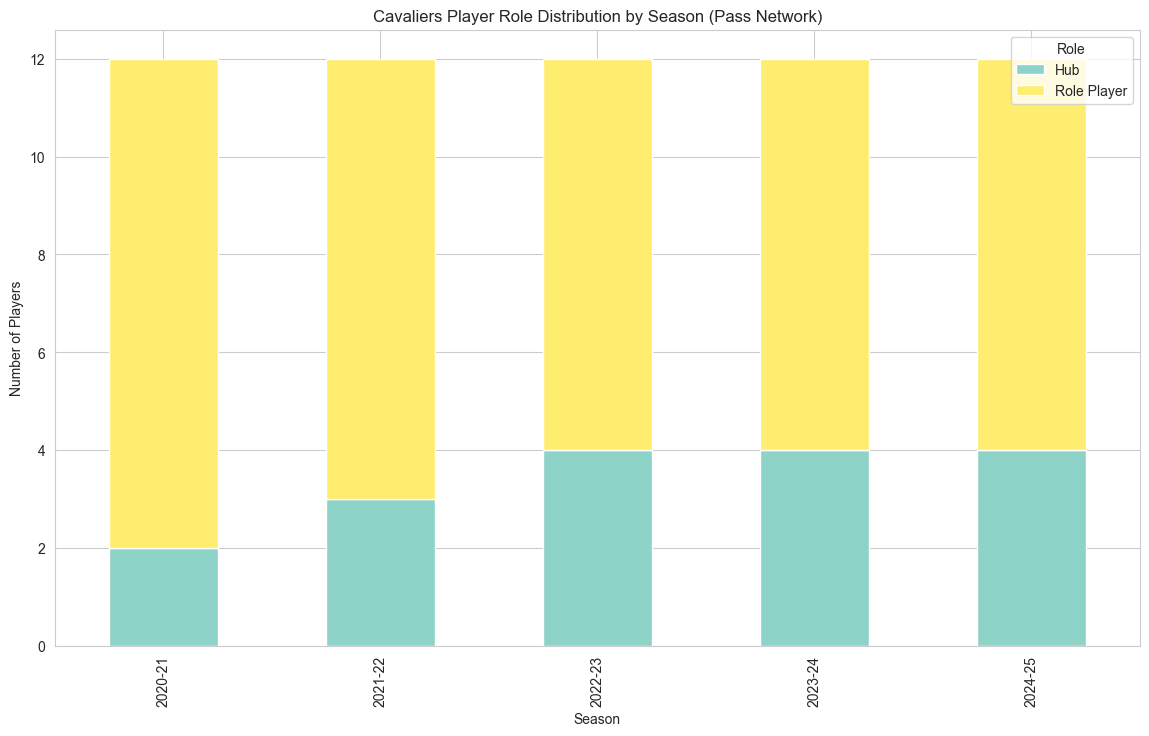

In [20]:
# Plot a stacked bar chart of role distribution per season
role_dist.plot(kind='bar', stacked=True, colormap='Set3')
plt.title('Cavaliers Player Role Distribution by Season (Pass Network)')
plt.xlabel('Season')
plt.ylabel('Number of Players')
plt.legend(title='Role')
plt.savefig(f'{OUTPUT_DIR}/Cavaliers_role_distribution_pass_network.png', dpi=300)
plt.show()